<a href="https://colab.research.google.com/github/mohadesehsotoudehnia/FIS-projects/blob/main/Part1_FinalProject%20/%20FIS4041_Final_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Q2***

# **PART A**

# Environment Setup and Imports

In [ ]:
!pip -q install gdown

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

RANDOM_STATE = 43

# Dataset Download Using gdown

In [ ]:
file_id = "1v_jcmsTRBd3Is92swEOlq3RM44XjsLqH"
output_name = "data.csv"

!gdown --id $file_id -O $output_name

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1v_jcmsTRBd3Is92swEOlq3RM44XjsLqH
To: /content/data.csv
100% 3.98k/3.98k [00:00<00:00, 16.4MB/s]


# Dataset Loading and File Type Handling

In [ ]:
import os

path = output_name
ext = os.path.splitext(path)[1].lower()

if ext in [".csv", ".txt"]:
    df = pd.read_csv(path)
elif ext in [".xlsx", ".xls"]:
    df = pd.read_excel(path)
else:
    df = pd.read_csv(path)

print("Shape:", df.shape)
df.head()

Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Data Cleaning and Duplicate Removal

In [ ]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Duplicate rows removed: {before - after}")

missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column (top 15):")
print(missing.head(15))

Duplicate rows removed: 0
Missing values per column (top 15):
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


# Target Variable Identification

In [ ]:
TARGET_COL = None

if TARGET_COL is None:
    candidates = ["target", "label", "class", "y", "outcome"]
    found = [c for c in candidates if c in df.columns]
    if len(found) > 0:
        TARGET_COL = found[0]
    else:
        TARGET_COL = df.columns[-1]

print("Target column selected:", TARGET_COL)

Target column selected: Spending Score (1-100)


# Feature–Target Separation and Train–Test Split

In [ ]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (160, 4) Test shape: (40, 4)


# Feature Type Detection

In [ ]:
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 3
Categorical features: 1


# Numerical Feature Scaling and Encoding

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

# Preprocessing Pipeline Construction

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("Processed train shape:", X_train_processed.shape)
print("Processed test shape:", X_test_processed.shape)

Processed train shape: (160, 5)
Processed test shape: (40, 5)


# Preprocessed Data Generation

In [ ]:
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)

X_train_pca2 = pca_2d.fit_transform(X_train_processed)
X_test_pca2  = pca_2d.transform(X_test_processed)

print("PCA Train shape:", X_train_pca2.shape)
print("Explained variance ratio:", pca_2d.explained_variance_ratio_)
print("Total explained variance:", pca_2d.explained_variance_ratio_.sum())

PCA Train shape: (160, 2)
Explained variance ratio: [0.56801611 0.28594016]
Total explained variance: 0.8539562740572276


# Two-Dimensional PCA for Visualization

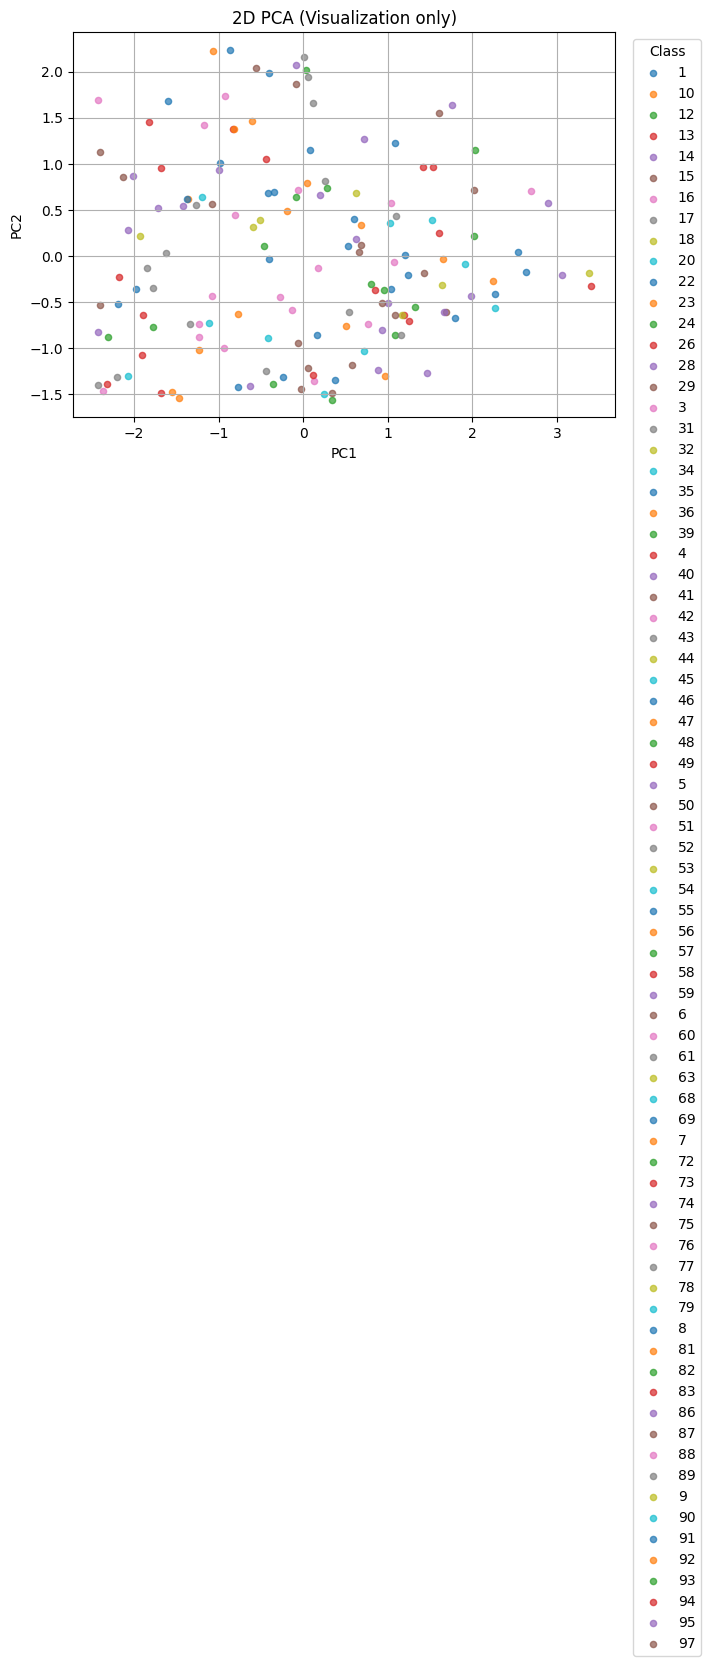

In [ ]:
plt.figure(figsize=(7,5))

y_vis = y_train.astype(str)

for cls in sorted(y_vis.unique()):
    idx = (y_vis == cls).values
    plt.scatter(X_train_pca2[idx, 0], X_train_pca2[idx, 1], s=20, alpha=0.7, label=cls)

plt.title("2D PCA (Visualization only)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.show()

# **PART B**

# Imports and Random State

In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

RANDOM_STATE = 43

# Check Preprocessed Training Data

In [ ]:
try:
    print("✅ X_train_processed shape:", X_train_processed.shape)
except NameError:
    raise NameError("❌ X_train_processed not found. Please run part (a) preprocessing first.")

✅ X_train_processed shape: (160, 5)


# Train KMeans for K = 2..10 (Stable Settings)

In [ ]:
K_values = list(range(2, 11))

inertias = []
silhouettes = []

for k in K_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init=30,
        algorithm="lloyd"
    )

    labels = kmeans.fit_predict(X_train_processed)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_train_processed, labels))

# Results Table (Inertia + Silhouette)

In [ ]:
results_df = pd.DataFrame({
    "K": K_values,
    "Inertia": inertias,
    "Silhouette": silhouettes
})

results_df

,K,Inertia,Silhouette
0,2,333.126979,0.346795
1,3,240.323099,0.345884
2,4,196.599915,0.298832
3,5,170.380739,0.320917
4,6,145.731593,0.334974
5,7,129.545371,0.328691
6,8,115.019937,0.350498
7,9,102.122169,0.364428
8,10,90.632511,0.357354


# Plot Elbow Curve (Inertia vs K)

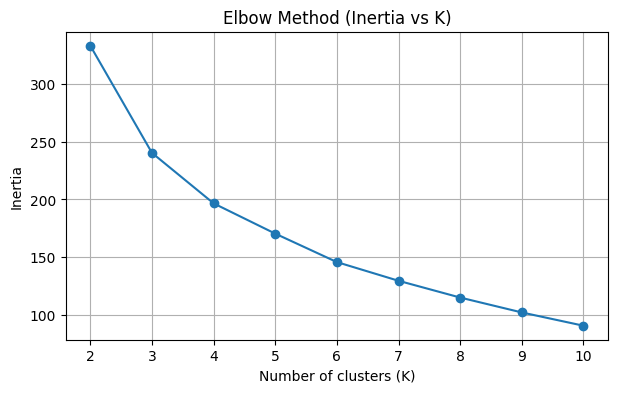

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(results_df["K"], results_df["Inertia"], marker="o")
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Plot Silhouette Score vs K

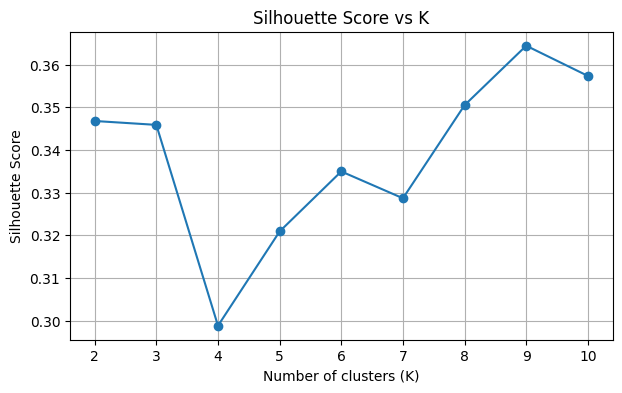

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(results_df["K"], results_df["Silhouette"], marker="o")
plt.title("Silhouette Score vs K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Choose Final K (Best Silhouette + Simpler K Rule)

In [ ]:
best_sil = results_df["Silhouette"].max()
best_k = int(results_df.loc[results_df["Silhouette"].idxmax(), "K"])

tolerance = 0.02
threshold = best_sil - tolerance

candidates = results_df[results_df["Silhouette"] >= threshold].copy()
FINAL_K = int(candidates["K"].min())

print("✅ Best K by Silhouette:", best_k, "| Best silhouette:", best_sil)
print("Candidates within", tolerance, "of best silhouette:", candidates["K"].tolist())
print("✅ FINAL_K (simpler & close-to-best):", FINAL_K)

✅ Best K by Silhouette: 9 | Best silhouette: 0.3644277746669216
Candidates within 0.02 of best silhouette: [2, 3, 8, 9, 10]
✅ FINAL_K (simpler & close-to-best): 2


# Train Final KMeans Model with FINAL_K

In [ ]:
final_kmeans = KMeans(
    n_clusters=FINAL_K,
    random_state=RANDOM_STATE,
    n_init=30,
    algorithm="lloyd"
)

final_labels = final_kmeans.fit_predict(X_train_processed)

final_inertia = final_kmeans.inertia_
final_sil = silhouette_score(X_train_processed, final_labels)

print("Final model trained with K =", FINAL_K)
print("Final inertia:", final_inertia)
print("Final silhouette:", final_sil)

Final model trained with K = 2
Final inertia: 333.1269793970762
Final silhouette: 0.34679512814245694


# Visualize Final Clusters on 2D PCA

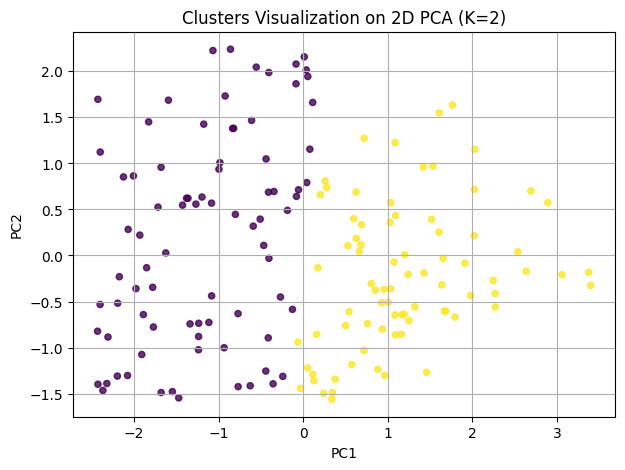

In [ ]:
try:
    X_train_pca2
    plt.figure(figsize=(7,5))
    plt.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=final_labels, s=20, alpha=0.8)
    plt.title(f"Clusters Visualization on 2D PCA (K={FINAL_K})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()
except NameError:
    print("X_train_pca2 not found. (PCA visualization was not computed in part a.)")

# Save Results

In [ ]:
results_df.to_csv("kmeans_k2_10_results.csv", index=False)
print("Saved: kmeans_k2_10_results.csv")

Saved: kmeans_k2_10_results.csv


# Short Text for Report (Auto-Generated)

In [ ]:
print(
    f"For K=2..10, KMeans was trained and inertia/silhouette were computed. "
    f"The best silhouette was {best_sil:.3f} at K={best_k}. "
    f"Using a simplicity rule (within {tolerance} of best), FINAL_K was selected as {FINAL_K}."
)

For K=2..10, KMeans was trained and inertia/silhouette were computed. The best silhouette was 0.364 at K=9. Using a simplicity rule (within 0.02 of best), FINAL_K was selected as 2.


# **PART C**

# Imports

In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Check Preprocessed Training Data

In [ ]:
try:
    print("✅ X_train_processed shape:", X_train_processed.shape)
except NameError:
    raise NameError("❌ X_train_processed not found. Please run part (a) first.")

✅ X_train_processed shape: (160, 5)


# Define Linkage Methods and K Range

In [ ]:
linkages = ["single", "complete", "average", "ward"]
K_values = list(range(2, 11))

# Run Agglomerative Clustering for All Linkages and K

In [ ]:
results = []

for linkage in linkages:
    for k in K_values:

        if linkage == "ward":
            model = AgglomerativeClustering(
                n_clusters=k,
                linkage=linkage
            )
        else:
            model = AgglomerativeClustering(
                n_clusters=k,
                linkage=linkage
            )

        labels = model.fit_predict(X_train_processed)
        sil = silhouette_score(X_train_processed, labels)

        results.append({
            "Linkage": linkage,
            "K": k,
            "Silhouette": sil
        })

# Results Table

In [ ]:
results_df = pd.DataFrame(results)
results_df.head()
results_df.sort_values("Silhouette", ascending=False).head(10)

,Linkage,K,Silhouette
35,ward,10,0.358076
34,ward,9,0.351253
9,complete,2,0.337250
33,ward,8,0.335394
18,average,2,0.331003
32,ward,7,0.321679
27,ward,2,0.312759
23,average,7,0.310348
26,average,10,0.303426
24,average,8,0.301959


# Plot Silhouette vs K for Each Linkage

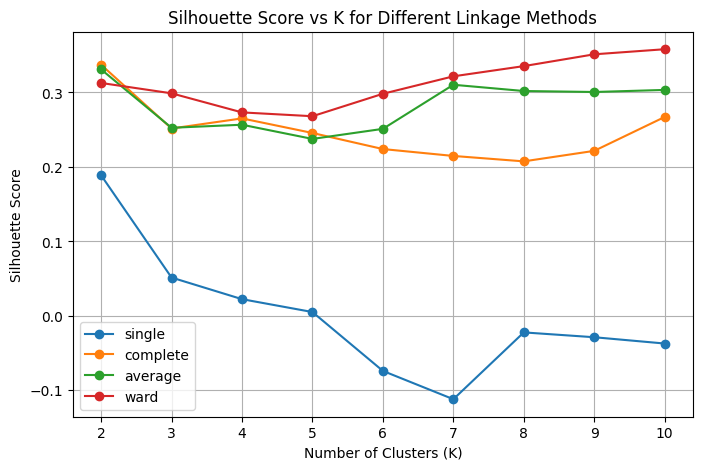

In [ ]:
plt.figure(figsize=(8,5))

for linkage in linkages:
    subset = results_df[results_df["Linkage"] == linkage]
    plt.plot(subset["K"], subset["Silhouette"], marker="o", label=linkage)

plt.title("Silhouette Score vs K for Different Linkage Methods")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

# Find Best (Linkage, K) by Silhouette

In [ ]:
best_row = results_df.loc[results_df["Silhouette"].idxmax()]

BEST_LINKAGE = best_row["Linkage"]
BEST_K = int(best_row["K"])
BEST_SIL = best_row["Silhouette"]

print("✅ Best linkage:", BEST_LINKAGE)
print("✅ Best K:", BEST_K)
print("Silhouette score:", BEST_SIL)

✅ Best linkage: ward
✅ Best K: 10
Silhouette score: 0.3580763577330651


# Prefer Simpler K if Close

In [ ]:
tolerance = 0.02
threshold = BEST_SIL - tolerance

candidates = results_df[
    (results_df["Silhouette"] >= threshold) &
    (results_df["Linkage"] == BEST_LINKAGE)
]

FINAL_K = int(candidates["K"].min())

print("Candidate Ks for best linkage:", candidates["K"].tolist())
print("✅ FINAL_K (simpler choice):", FINAL_K)

Candidate Ks for best linkage: [9, 10]
✅ FINAL_K (simpler choice): 9


# Train Final Agglomerative Model

In [ ]:
final_agg = AgglomerativeClustering(
    n_clusters=FINAL_K,
    linkage=BEST_LINKAGE
)

final_labels = final_agg.fit_predict(X_train_processed)

final_silhouette = silhouette_score(X_train_processed, final_labels)

print("Final Agglomerative Model")
print("Linkage:", BEST_LINKAGE)
print("K:", FINAL_K)
print("Silhouette:", final_silhouette)

Final Agglomerative Model
Linkage: ward
K: 9
Silhouette: 0.351252747209711


# Visualize on 2D PCA

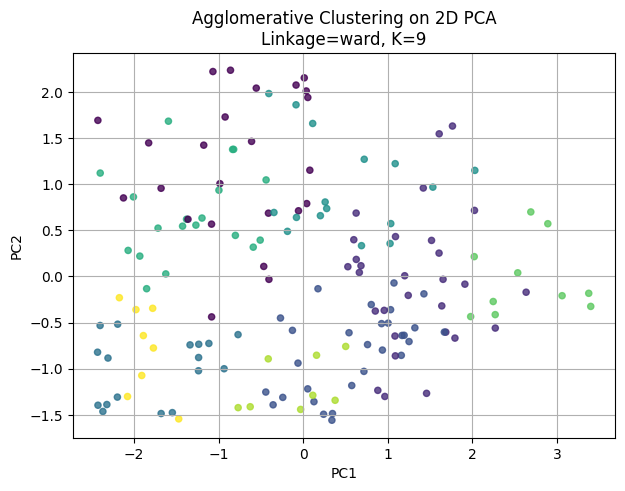

In [ ]:
try:
    X_train_pca2
    plt.figure(figsize=(7,5))
    plt.scatter(
        X_train_pca2[:, 0],
        X_train_pca2[:, 1],
        c=final_labels,
        s=20,
        alpha=0.8
    )
    plt.title(f"Agglomerative Clustering on 2D PCA\nLinkage={BEST_LINKAGE}, K={FINAL_K}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()
except NameError:
    print("X_train_pca2 not found (PCA visualization skipped).")

# **PART D**

# Imports

In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Check Preprocessed Training Data

In [ ]:
try:
    print("✅ X_train_processed shape:", X_train_processed.shape)
except NameError:
    raise NameError("❌ X_train_processed not found. Please run part (a) first.")

✅ X_train_processed shape: (160, 5)


# Define Parameter Grid

In [ ]:
eps_list = [0.2, 0.4, 0.6, 0.8, 1.0]
min_samples_list = [3, 5, 10]

# Helper Function (Silhouette on Non-Noise Only)

In [ ]:
def silhouette_on_non_noise(X, labels):
    """
    Computes silhouette only on non-noise points (labels != -1).
    Returns np.nan if silhouette is not valid (needs >=2 clusters).
    """
    mask = labels != -1
    X_nn = X[mask]
    labels_nn = labels[mask]

    unique_clusters = set(labels_nn)
    if len(unique_clusters) < 2:
        return np.nan

    if X_nn.shape[0] < 2:
        return np.nan

    return silhouette_score(X_nn, labels_nn)

# Run DBSCAN for All (eps, min_samples)

In [ ]:
results = []

X_np = X_train_processed
try:
    X_np = X_train_processed.toarray()
except:
    X_np = X_train_processed

for eps in eps_list:
    for ms in min_samples_list:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X_np)

        n_total = len(labels)
        n_noise = np.sum(labels == -1)
        noise_ratio = n_noise / n_total

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        sil_nn = silhouette_on_non_noise(X_np, labels)

        results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_ratio": noise_ratio,
            "silhouette_non_noise": sil_nn
        })

# Results Table

In [ ]:
results_df = pd.DataFrame(results)
results_df

,eps,min_samples,n_clusters,noise_ratio,silhouette_non_noise
0,0.2,3,10,0.75000,0.763570
1,0.2,5,2,0.93750,0.924597
2,0.2,10,0,1.00000,NaN
3,0.4,3,16,0.30000,0.415505
4,0.4,5,8,0.60000,0.583671
5,0.4,10,1,0.93125,NaN
6,0.6,3,6,0.05625,0.090042
7,0.6,5,5,0.18750,0.155309
8,0.6,10,2,0.71250,0.503426
9,0.8,3,2,0.00625,0.189899


In [ ]:
results_df.sort_values("silhouette_non_noise", ascending=False).head(10)

,eps,min_samples,n_clusters,noise_ratio,silhouette_non_noise
1,0.2,5,2,0.93750,0.924597
0,0.2,3,10,0.75000,0.763570
4,0.4,5,8,0.60000,0.583671
8,0.6,10,2,0.71250,0.503426
3,0.4,3,16,0.30000,0.415505
11,0.8,10,2,0.36250,0.292956
14,1.0,10,2,0.10000,0.210496
9,0.8,3,2,0.00625,0.189899
12,1.0,3,2,0.00000,0.188836
13,1.0,5,2,0.00000,0.188836


# Plot Silhouette Heatmap

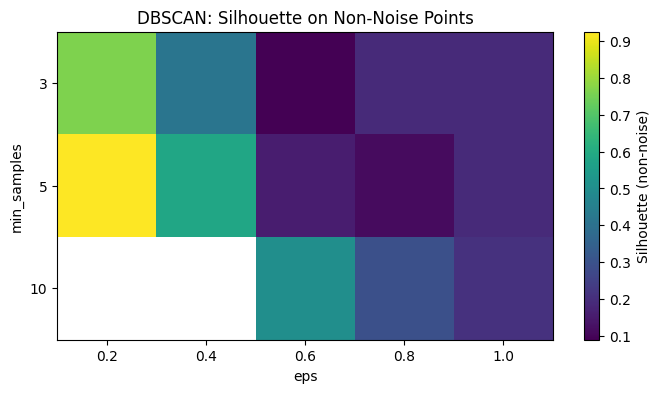

In [ ]:
pivot_sil = results_df.pivot(index="min_samples", columns="eps", values="silhouette_non_noise")

plt.figure(figsize=(8,4))
plt.imshow(pivot_sil.values, aspect="auto")
plt.xticks(range(len(pivot_sil.columns)), pivot_sil.columns)
plt.yticks(range(len(pivot_sil.index)), pivot_sil.index)
plt.colorbar(label="Silhouette (non-noise)")
plt.title("DBSCAN: Silhouette on Non-Noise Points")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.show()

# Plot Noise Ratio Heatmap

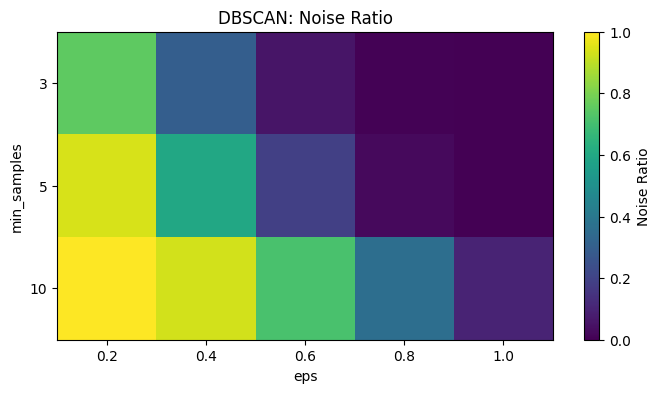

In [ ]:
pivot_noise = results_df.pivot(index="min_samples", columns="eps", values="noise_ratio")

plt.figure(figsize=(8,4))
plt.imshow(pivot_noise.values, aspect="auto")
plt.xticks(range(len(pivot_noise.columns)), pivot_noise.columns)
plt.yticks(range(len(pivot_noise.index)), pivot_noise.index)
plt.colorbar(label="Noise Ratio")
plt.title("DBSCAN: Noise Ratio")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.show()

# Choose Best Setting (Reasoned Selection)

In [ ]:
valid_df = results_df[
    (results_df["n_clusters"] >= 2) &
    (results_df["silhouette_non_noise"].notna())
].copy()

if valid_df.shape[0] == 0:
    print("❌ No valid DBSCAN setting found (silhouette not computable for all).")
    print("Try larger eps values or different min_samples.")
else:
    best_sil = valid_df["silhouette_non_noise"].max()

    tolerance = 0.02
    cand = valid_df[valid_df["silhouette_non_noise"] >= best_sil - tolerance].copy()

    cand = cand.sort_values(["noise_ratio", "silhouette_non_noise"], ascending=[True, False])

    best_row = cand.iloc[0]
    BEST_EPS = float(best_row["eps"])
    BEST_MIN_SAMPLES = int(best_row["min_samples"])

    print("✅ Best settings selected:")
    print("eps =", BEST_EPS)
    print("min_samples =", BEST_MIN_SAMPLES)
    print("n_clusters =", int(best_row["n_clusters"]))
    print("noise_ratio =", float(best_row["noise_ratio"]))
    print("silhouette_non_noise =", float(best_row["silhouette_non_noise"]))

✅ Best settings selected:
eps = 0.2
min_samples = 5
n_clusters = 2
noise_ratio = 0.9375
silhouette_non_noise = 0.9245973505942789


# Fit Final DBSCAN Model with Best Params

In [ ]:
final_dbscan = DBSCAN(eps=BEST_EPS, min_samples=BEST_MIN_SAMPLES)
final_labels = final_dbscan.fit_predict(X_np)

n_clusters_final = len(set(final_labels)) - (1 if -1 in final_labels else 0)
noise_ratio_final = np.mean(final_labels == -1)
sil_final = silhouette_on_non_noise(X_np, final_labels)

print("Final DBSCAN Result")
print("eps:", BEST_EPS, "| min_samples:", BEST_MIN_SAMPLES)
print("n_clusters:", n_clusters_final)
print("noise_ratio:", noise_ratio_final)
print("silhouette_non_noise:", sil_final)

Final DBSCAN Result
eps: 0.2 | min_samples: 5
n_clusters: 2
noise_ratio: 0.9375
silhouette_non_noise: 0.9245973505942789


# Visualize DBSCAN Clusters on 2D PCA

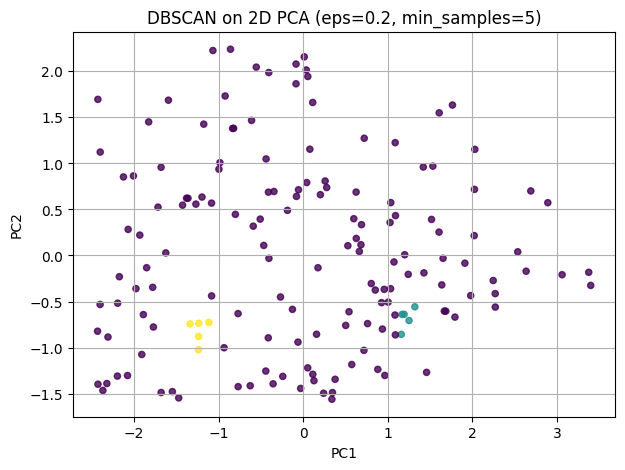

In [ ]:
try:
    X_train_pca2
    plt.figure(figsize=(7,5))
    plt.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=final_labels, s=20, alpha=0.8)
    plt.title(f"DBSCAN on 2D PCA (eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()
except NameError:
    print("X_train_pca2 not found (PCA visualization skipped).")

# Filter and Sort DBSCAN Results (Valid Settings)

In [ ]:
balanced_df = results_df[
    (results_df["silhouette_non_noise"].notna()) &
    (results_df["noise_ratio"] <= 0.5) &
    (results_df["n_clusters"] >= 2)
]

balanced_df.sort_values("silhouette_non_noise", ascending=False).head(10)

,eps,min_samples,n_clusters,noise_ratio,silhouette_non_noise
3,0.4,3,16,0.30000,0.415505
11,0.8,10,2,0.36250,0.292956
14,1.0,10,2,0.10000,0.210496
9,0.8,3,2,0.00625,0.189899
12,1.0,3,2,0.00000,0.188836
13,1.0,5,2,0.00000,0.188836
7,0.6,5,5,0.18750,0.155309
10,0.8,5,3,0.02500,0.113415
6,0.6,3,6,0.05625,0.090042


# Final DBSCAN Model Training and Report

In [ ]:
final_dbscan = DBSCAN(eps=0.4, min_samples=3)
final_labels = final_dbscan.fit_predict(X_np)

print("Final DBSCAN (balanced choice)")
print("n_clusters:", len(set(final_labels)) - (1 if -1 in final_labels else 0))
print("noise_ratio:", np.mean(final_labels == -1))
print("silhouette_non_noise:", silhouette_on_non_noise(X_np, final_labels))

Final DBSCAN (balanced choice)
n_clusters: 16
noise_ratio: 0.3
silhouette_non_noise: 0.4155046578920221


# **PART E**

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Preprocessing Check

In [ ]:
try:
    print("✅ X_train_processed shape:", X_train_processed.shape)
except NameError:
    raise NameError("❌ X_train_processed not found. Please run previous preprocessing steps first.")

✅ X_train_processed shape: (160, 5)


# Apply DBSCAN with Best Parameters

In [ ]:
final_dbscan = DBSCAN(eps=0.4, min_samples=3)
final_labels = final_dbscan.fit_predict(X_train_processed)

n_clusters_final = len(set(final_labels)) - (1 if -1 in final_labels else 0)
noise_ratio_final = np.mean(final_labels == -1)

print("Final DBSCAN Result")
print(f"n_clusters: {n_clusters_final}")
print(f"noise_ratio: {noise_ratio_final:.4f}")

Final DBSCAN Result
n_clusters: 16
noise_ratio: 0.3000


# Reduce Data to 2D for PCA

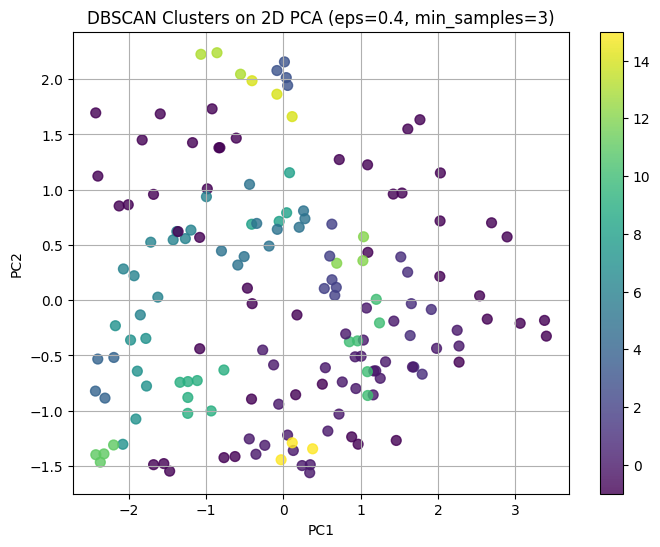

In [ ]:
pca = PCA(n_components=2)
X_train_pca2 = pca.fit_transform(X_train_processed)


plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=final_labels, cmap='viridis', s=50, alpha=0.8)


plt.title(f"DBSCAN Clusters on 2D PCA (eps=0.4, min_samples=3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter)
plt.grid(True)
plt.show()